# 📝 Exercise M7.02

We presented different classification metrics in the previous notebook.
However, we did not use it with a cross-validation. This exercise aims at
practicing and implementing cross-validation.

We will reuse the blood transfusion dataset.

In [1]:
import os

os.makedirs("../../datasets", exist_ok=True)

In [2]:
%%bash

wget -qO "../../datasets/blood_transfusion.csv" "https://github.com/INRIA/scikit-learn-mooc/raw/master/datasets/blood_transfusion.csv"

In [4]:
import pandas as pd

blood_transfusion = pd.read_csv("../../datasets/blood_transfusion.csv")
data = blood_transfusion.drop(columns="Class")
target = blood_transfusion["Class"]
blood_transfusion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Recency    748 non-null    int64 
 1   Frequency  748 non-null    int64 
 2   Monetary   748 non-null    int64 
 3   Time       748 non-null    int64 
 4   Class      748 non-null    object
dtypes: int64(4), object(1)
memory usage: 29.3+ KB


<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">If you want a deeper overview regarding this dataset, you can refer to the
Appendix - Datasets description section at the end of this MOOC.</p>
</div>

We can display an interactive diagram with the following command:

In [5]:
from sklearn import set_config
set_config(display='diagram')

First, create a decision tree classifier.

In [6]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=0)
tree

DecisionTreeClassifier(random_state=0)

Create a `StratifiedKFold` cross-validation object. Then use it inside the
`cross_val_score` function to evaluate the decision tree. We will first use
the accuracy as a score function. Explicitly use the `scoring` parameter
of `cross_val_score` to compute the accuracy (even if this is the default
score). Check its documentation to learn how to do that.

In [8]:
%%time
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=10)
scores = cross_val_score(tree, data, target, 
    cv=cv, scoring="accuracy")
print(f"Accuracy score: {scores.mean():.3f} +/- {scores.std():.3f}")

Accuracy score: 0.635 +/- 0.136
CPU times: user 59.5 ms, sys: 3.39 ms, total: 62.9 ms
Wall time: 61 ms


Repeat the experiment by computing the `balanced_accuracy`.

In [9]:
%%time
scores = cross_val_score(tree, data, target, 
    cv=cv, scoring="balanced_accuracy")
print(f"Balanced accuracy score: {scores.mean():.3f} +/- {scores.std():.3f}")

Balanced accuracy score: 0.516 +/- 0.100
CPU times: user 81 ms, sys: 0 ns, total: 81 ms
Wall time: 79.5 ms


We will now add a bit of complexity. We would like to compute the precision
of our model. However, during the course we saw that we need to mention the
positive label which in our case we consider to be the class `donated`.

We will show that computing the precision without providing the positive
label will not be supported by scikit-learn because it is indeed ambiguous.

In [10]:
%%time
try:
    scores = cross_val_score(tree, data, target, 
        cv=10, scoring="precision")
except ValueError as exc:
    print(exc)

CPU times: user 68.1 ms, sys: 0 ns, total: 68.1 ms
Wall time: 67.6 ms


/opt/conda/envs/notebook/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/envs/notebook/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "/opt/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/opt/conda/envs/notebook/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/conda/envs/notebook/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1656, in

<div class="admonition tip alert alert-warning">
<p class="first admonition-title" style="font-weight: bold;">Tip</p>
<p class="last">We catch the exception with a <tt class="docutils literal">try</tt>/<tt class="docutils literal">except</tt> pattern to be able to print it.</p>
</div>

We get an exception because the default scorer has its positive label set to
one (`pos_label=1`), which is not our case (our positive label is "donated").
In this case, we need to create a scorer using the scoring function and the
helper function `make_scorer`.

So, import `sklearn.metrics.make_scorer` and
`sklearn.metrics.precision_score`. Check their documentations for more
information.
Finally, create a scorer by calling `make_scorer` using the score function
`precision_score` and pass the extra parameter `pos_label="donated"`.

In [11]:
from sklearn.metrics import make_scorer, precision_score

precision = make_scorer(precision_score, pos_label='donated')

make_scorer(precision_score, pos_label=donated)

Now, instead of providing the string `"precision"` to the `scoring` parameter
in the `cross_val_score` call, pass the scorer that you created above.

In [12]:
%%time
scores = cross_val_score(tree, data, target,
    cv=cv, scoring=precision)
print(f"Precision score: {scores.mean():.3f} +/- {scores.std():.3f}")

Precision score: 0.264 +/- 0.159
CPU times: user 71.1 ms, sys: 7.16 ms, total: 78.3 ms
Wall time: 77.4 ms


`cross_val_score` will only compute a single score provided to the `scoring`
parameter. The function `cross_validate` allows the computation of multiple
scores by passing a list of string or scorer to the parameter `scoring`,
which could be handy.

Import `sklearn.model_selection.cross_validate` and compute the accuracy and
balanced accuracy through cross-validation. Plot the cross-validation score
for both metrics using a box plot.

In [13]:
%%time
from sklearn.model_selection import cross_validate
scoring = ["accuracy", "balanced_accuracy"]

scores = cross_validate(tree, data, target, 
    cv=cv, scoring=scoring)
scores

CPU times: user 60.1 ms, sys: 0 ns, total: 60.1 ms
Wall time: 58.1 ms


{'fit_time': array([0.00413084, 0.00385785, 0.00379515, 0.00265455, 0.00266767,
        0.00266409, 0.00306654, 0.00295711, 0.00270104, 0.00268269]),
 'score_time': array([0.0026443 , 0.00255823, 0.00249171, 0.0018127 , 0.00181508,
        0.00194764, 0.00205445, 0.00188613, 0.00181222, 0.00178623]),
 'test_accuracy': array([0.29333333, 0.54666667, 0.77333333, 0.57333333, 0.65333333,
        0.64      , 0.70666667, 0.76      , 0.64864865, 0.75675676]),
 'test_balanced_accuracy': array([0.42105263, 0.49269006, 0.66081871, 0.41520468, 0.48684211,
        0.42105263, 0.55994152, 0.72807018, 0.4623323 , 0.51186791])}

In [14]:
import pandas as pd

color = {"whiskers": "black", "medians": "black", "caps": "black"}

metrics = pd.DataFrame([
    scores['test_accuracy'], scores['test_balanced_accuracy']], 
    index=['Accuracy', 'Balanced accuracy']).T
metrics.head()

,Accuracy,Balanced accuracy
0,0.293333,0.421053
1,0.546667,0.492690
2,0.773333,0.660819
3,0.573333,0.415205
4,0.653333,0.486842


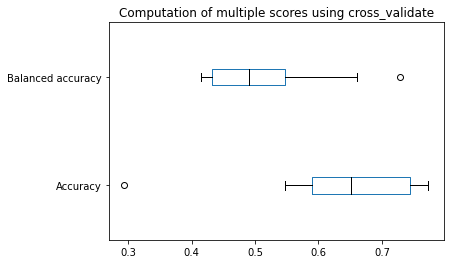

In [15]:
import matplotlib.pyplot as plt

metrics.plot.box(vert=False, color=color)
_ = plt.title("Computation of multiple scores using cross_validate")